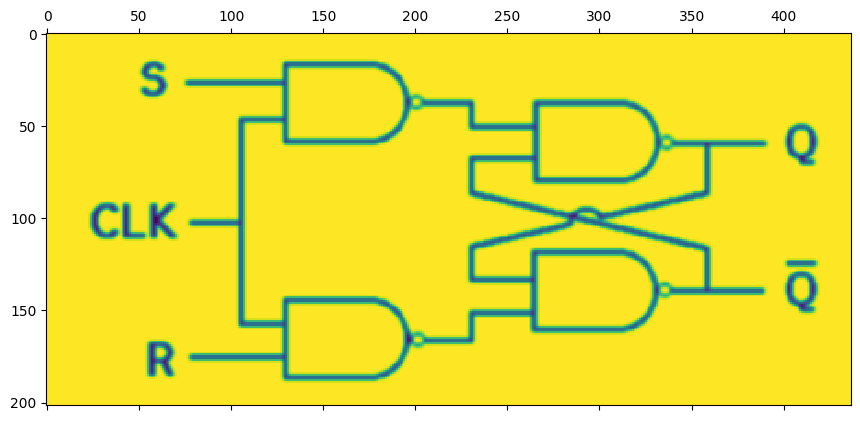

In [3]:
import numpy as np

import cv2
import matplotlib.pyplot as plt

circuit_filename = "/Users/nshelton/Pictures/SR-flip-flop.png"

img = cv2.imread(circuit_filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

plt.matshow(blurred)


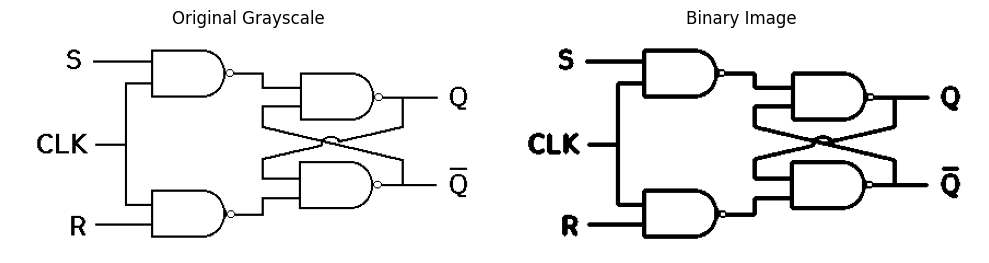

In [4]:
# Create binary image using Otsu's thresholding
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title('Original Grayscale')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')
plt.axis('off')
plt.tight_layout()
plt.show()

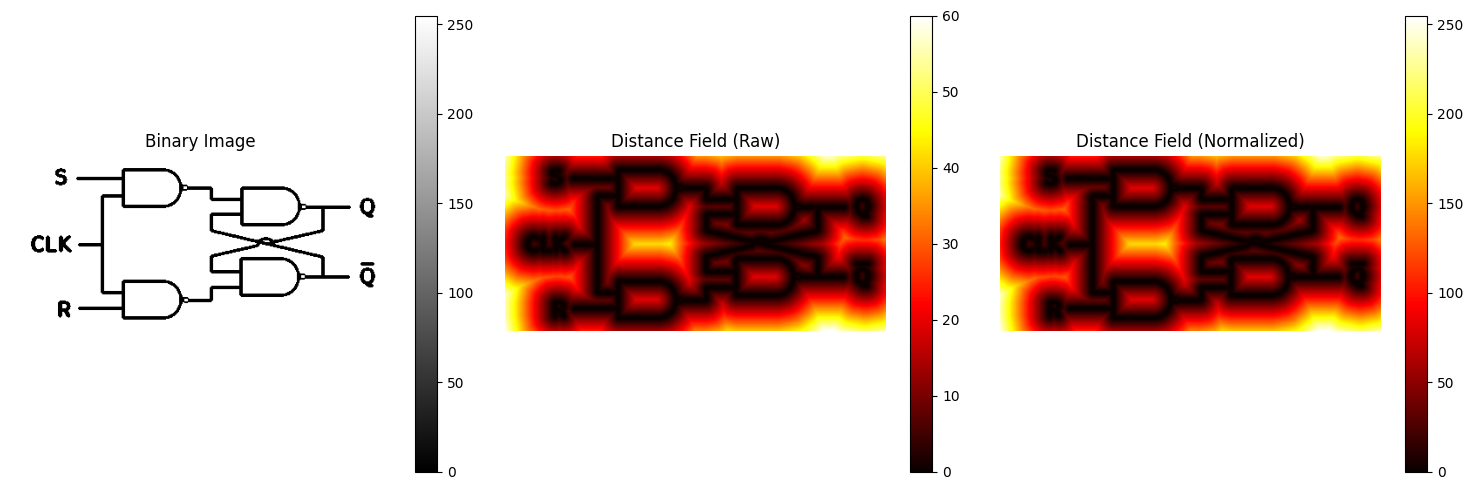

Distance field range: 0.00 to 60.00


In [5]:
# Compute distance transform
# distanceTransform calculates the distance to the nearest zero pixel
distance_field = cv2.distanceTransform(binary, cv2.DIST_L2, 5)

# Normalize for better visualization
distance_normalized = cv2.normalize(distance_field, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(distance_field, cmap='hot')
plt.title('Distance Field (Raw)')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(distance_normalized, cmap='hot')
plt.title('Distance Field (Normalized)')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Distance field range: {distance_field.min():.2f} to {distance_field.max():.2f}")

In [7]:
binary = 255 - binary

## Centerline Extraction Techniques

We'll explore several methods to extract centerlines from the distance field:
1. **Skeletonization** - Morphological thinning
2. **Ridge Detection** - Finding local maxima in the distance field
3. **Distance Field Thresholding** - Using only high-distance regions

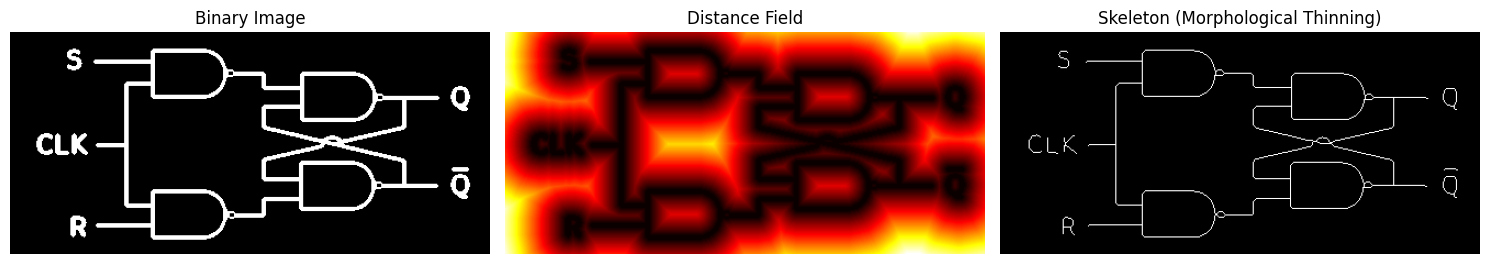

In [8]:
# Method 1: Skeletonization using Zhang-Suen thinning
from skimage.morphology import skeletonize

# Skeletonize requires boolean array
skeleton = skeletonize(binary > 0)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(distance_field, cmap='hot')
plt.title('Distance Field')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(skeleton, cmap='gray')
plt.title('Skeleton (Morphological Thinning)')
plt.axis('off')

plt.tight_layout()
plt.show()

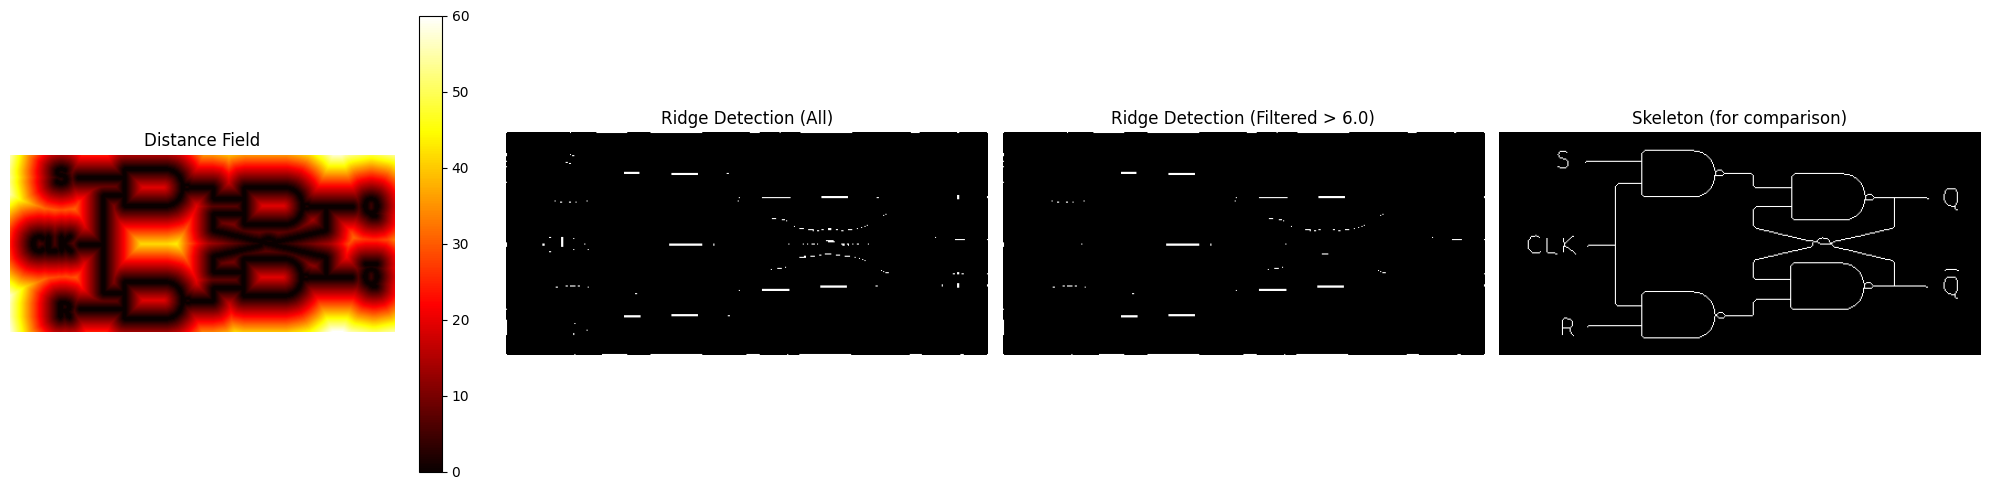

In [9]:
# Method 2: Ridge detection - find local maxima in the distance field
from scipy.ndimage import maximum_filter

# Find local maxima by comparing with a dilated version
# A pixel is a ridge point if it's equal to the maximum in its neighborhood
footprint_size = 3
local_max = maximum_filter(distance_field, size=footprint_size)
ridges = (distance_field == local_max) & (distance_field > 0)

# Optional: filter by minimum distance threshold to remove noise
threshold = distance_field.max() * 0.1  # Keep only ridges with significant distance
ridges_filtered = ridges & (distance_field > threshold)

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(distance_field, cmap='hot')
plt.title('Distance Field')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(ridges, cmap='gray')
plt.title('Ridge Detection (All)')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(ridges_filtered, cmap='gray')
plt.title(f'Ridge Detection (Filtered > {threshold:.1f})')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(skeleton, cmap='gray')
plt.title('Skeleton (for comparison)')
plt.axis('off')

plt.tight_layout()
plt.show()

## Converting Skeleton to Paths

Now let's convert the skeleton into actual path data (lists of connected points).

Found 24 contours
Total points across all contours: 3954


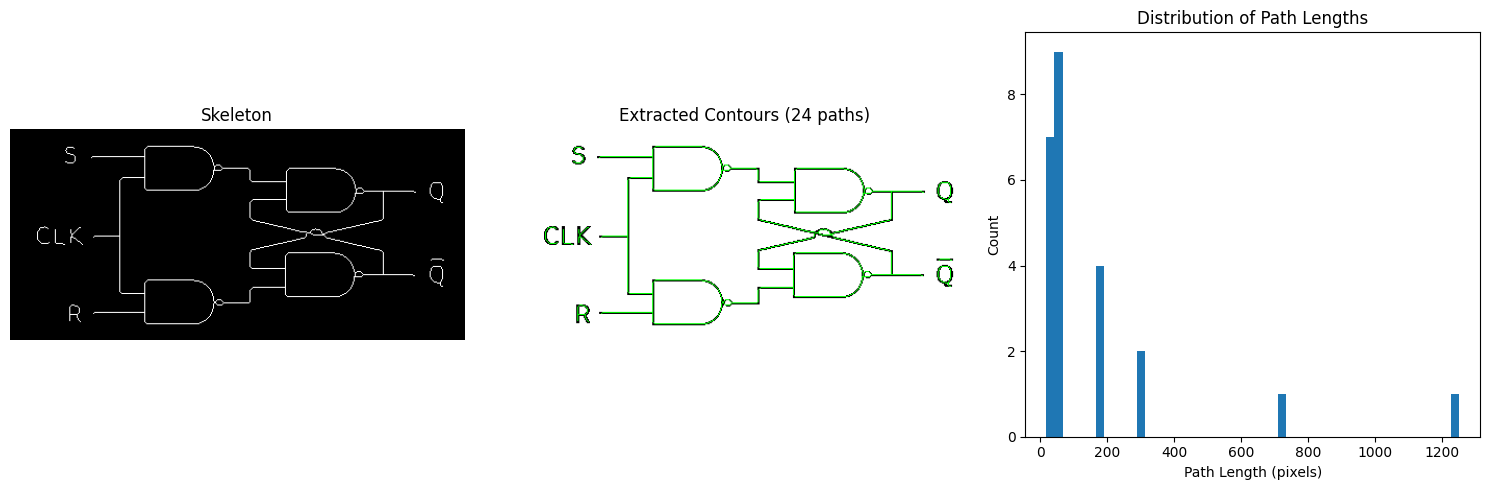


Top 5 longest paths:
  Path 1: 1252 points
  Path 2: 718 points
  Path 3: 311 points
  Path 4: 309 points
  Path 5: 188 points


In [10]:
# Method 1: Simple contour extraction
# Convert skeleton to uint8 for contour detection
skeleton_uint8 = (skeleton * 255).astype(np.uint8)

# Find contours in the skeleton
contours, hierarchy = cv2.findContours(skeleton_uint8, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

print(f"Found {len(contours)} contours")
print(f"Total points across all contours: {sum(len(c) for c in contours)}")

# Visualize the contours
img_with_contours = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(skeleton, cmap='gray')
plt.title('Skeleton')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_with_contours)
plt.title(f'Extracted Contours ({len(contours)} paths)')
plt.axis('off')

# Show individual path lengths
plt.subplot(1, 3, 3)
path_lengths = [len(c) for c in contours]
plt.hist(path_lengths, bins=50)
plt.xlabel('Path Length (pixels)')
plt.ylabel('Count')
plt.title('Distribution of Path Lengths')

plt.tight_layout()
plt.show()

# Print info about longest paths
sorted_contours = sorted(contours, key=len, reverse=True)
print("\nTop 5 longest paths:")
for i, contour in enumerate(sorted_contours[:5]):
    print(f"  Path {i+1}: {len(contour)} points")